# Interactive multi-compartment OLM cell example

You can experiment with the example code we used in the previous section in this interactive notebook. Use the launcher button above to open this notebook in Binder or Google Colab. Please uncomment the line below if you use the Google Colab. (It does not include these packages by default).

In [1]:
#%pip install pyneuroml neuromllite NEURON

In [2]:
#!/usr/bin/env python3
"""
Multi-compartmental OLM cell example

File: olm-example.py

Copyright 2021 NeuroML contributors
Authors: Padraig Gleeson, Ankur Sinha
"""

from neuroml import (NeuroMLDocument, IncludeType, Population, PulseGenerator, ExplicitInput, Network, SegmentGroup, Member, Property, Include, Instance, Location)
from CellBuilder import (create_cell, add_segment, add_channel_density, set_init_memb_potential, set_resistivity, set_specific_capacitance, get_seg_group_by_id)
from pyneuroml import pynml
from pyneuroml.lems import LEMSSimulation
import numpy as np

The CellBuilder module file can be found in the same folder as the Python script. It is used to define the helper functions that we use in our main file.

## Declaring the NeuroML model
### Create the cell

In this example, we do not create the ion channels. We include ion channels that are already provided in NeuroML files. 

In [3]:

def create_olm_cell():
    """Create the complete cell.

    :returns: cell object
    """
    nml_cell_doc = NeuroMLDocument(id="oml_cell")
    cell = create_cell("olm")
    nml_cell_file = cell.id + ".cell.nml"

    # Add two soma segments
    diam = 10.0
    soma_0 = add_segment(cell,
                         prox=[0.0, 0.0, 0.0, diam],
                         dist=[0.0, 10., 0.0, diam],
                         name="Seg0_soma_0",
                         group="soma_0")

    soma_1 = add_segment(cell,
                         prox=None,
                         dist=[0.0, 10. + 10., 0.0, diam],
                         name="Seg1_soma_0",
                         parent=soma_0,
                         group="soma_0")

    # Add axon segments
    diam = 1.5
    axon_0 = add_segment(cell,
                         prox=[0.0, 0.0, 0.0, diam],
                         dist=[0.0, -75, 0.0, diam],
                         name="Seg0_axon_0",
                         parent=soma_0,
                         fraction_along=0.0,
                         group="axon_0")
    axon_1 = add_segment(cell,
                         prox=None,
                         dist=[0.0, -150, 0.0, diam],
                         name="Seg1_axon_0",
                         parent=axon_0,
                         group="axon_0")

    # Add 2 dendrite segments

    diam = 3.0
    dend_0_0 = add_segment(cell,
                           prox=[0.0, 20, 0.0, diam],
                           dist=[100, 120, 0.0, diam],
                           name="Seg0_dend_0",
                           parent=soma_1,
                           fraction_along=1,
                           group="dend_0")

    dend_1_0 = add_segment(cell,
                           prox=None,
                           dist=[177, 197, 0.0, diam],
                           name="Seg1_dend_0",
                           parent=dend_0_0,
                           fraction_along=1,
                           group="dend_0")

    dend_0_1 = add_segment(cell,
                           prox=[0.0, 20, 0.0, diam],
                           dist=[-100, 120, 0.0, diam],
                           name="Seg0_dend_1",
                           parent=soma_1,
                           fraction_along=1,
                           group="dend_1")
    dend_1_1 = add_segment(cell,
                           prox=None,
                           dist=[-177, 197, 0.0, diam],
                           name="Seg1_dend_1",
                           parent=dend_0_1,
                           fraction_along=1,
                           group="dend_1")

    # XXX: For segment groups to be correctly mapped to sections in NEURON,
    # they must include the correct neurolex ID
    for section_name in ["soma_0", "axon_0", "dend_0", "dend_1"]:
        section_group = get_seg_group_by_id(section_name, cell)
        section_group.neuro_lex_id = 'sao864921383'

    den_seg_group = get_seg_group_by_id("dendrite_group", cell)
    den_seg_group.includes.append(Include(segment_groups="dend_0"))
    den_seg_group.includes.append(Include(segment_groups="dend_1"))
    den_seg_group.properties.append(Property(tag="color", value="0.8 0 0"))

    ax_seg_group = get_seg_group_by_id("axon_group", cell)
    ax_seg_group.includes.append(Include(segment_groups="axon_0"))
    ax_seg_group.properties.append(Property(tag="color", value="0 0.8 0"))

    soma_seg_group = get_seg_group_by_id("soma_group", cell)
    soma_seg_group.includes.append(Include(segment_groups="soma_0"))

    soma_seg_group.properties.append(Property(tag="color", value="0 0 0.8"))

    # Other cell properties
    set_init_memb_potential(cell, "-67mV")
    set_resistivity(cell, "0.15 kohm_cm")
    set_specific_capacitance(cell, "1.3 uF_per_cm2")

    # channels
    # leak
    add_channel_density(cell, nml_cell_doc,
                        cd_id="leak_all",
                        cond_density="0.01 mS_per_cm2",
                        ion_channel="leak_chan",
                        ion_chan_def_file="olm-example/leak_chan.channel.nml",
                        erev="-67mV",
                        ion="non_specific")
    # HCNolm_soma
    add_channel_density(cell, nml_cell_doc,
                        cd_id="HCNolm_soma",
                        cond_density="0.5 mS_per_cm2",
                        ion_channel="HCNolm",
                        ion_chan_def_file="olm-example/HCNolm.channel.nml",
                        erev="-32.9mV",
                        ion="h",
                        group="soma_group")
    # Kdrfast_soma
    add_channel_density(cell, nml_cell_doc,
                        cd_id="Kdrfast_soma",
                        cond_density="73.37 mS_per_cm2",
                        ion_channel="Kdrfast",
                        ion_chan_def_file="olm-example/Kdrfast.channel.nml",
                        erev="-77mV",
                        ion="k",
                        group="soma_group")
    # Kdrfast_dendrite
    add_channel_density(cell, nml_cell_doc,
                        cd_id="Kdrfast_dendrite",
                        cond_density="105.8 mS_per_cm2",
                        ion_channel="Kdrfast",
                        ion_chan_def_file="olm-example/Kdrfast.channel.nml",
                        erev="-77mV",
                        ion="k",
                        group="dendrite_group")
    # Kdrfast_axon
    add_channel_density(cell, nml_cell_doc,
                        cd_id="Kdrfast_axon",
                        cond_density="117.392 mS_per_cm2",
                        ion_channel="Kdrfast",
                        ion_chan_def_file="olm-example/Kdrfast.channel.nml",
                        erev="-77mV",
                        ion="k",
                        group="axon_group")
    # KvAolm_soma
    add_channel_density(cell, nml_cell_doc,
                        cd_id="KvAolm_soma",
                        cond_density="4.95 mS_per_cm2",
                        ion_channel="KvAolm",
                        ion_chan_def_file="olm-example/KvAolm.channel.nml",
                        erev="-77mV",
                        ion="k",
                        group="soma_group")
    # KvAolm_dendrite
    add_channel_density(cell, nml_cell_doc,
                        cd_id="KvAolm_dendrite",
                        cond_density="2.8 mS_per_cm2",
                        ion_channel="KvAolm",
                        ion_chan_def_file="olm-example/KvAolm.channel.nml",
                        erev="-77mV",
                        ion="k",
                        group="dendrite_group")
    # Nav_soma
    add_channel_density(cell, nml_cell_doc,
                        cd_id="Nav_soma",
                        cond_density="10.7 mS_per_cm2",
                        ion_channel="Nav",
                        ion_chan_def_file="olm-example/Nav.channel.nml",
                        erev="50mV",
                        ion="na",
                        group="soma_group")
    # Nav_dendrite
    add_channel_density(cell, nml_cell_doc,
                        cd_id="Nav_dendrite",
                        cond_density="23.4 mS_per_cm2",
                        ion_channel="Nav",
                        ion_chan_def_file="olm-example/Nav.channel.nml",
                        erev="50mV",
                        ion="na",
                        group="dendrite_group")
    # Nav_axon
    add_channel_density(cell, nml_cell_doc,
                        cd_id="Nav_axon",
                        cond_density="17.12 mS_per_cm2",
                        ion_channel="Nav",
                        ion_chan_def_file="olm-example/Nav.channel.nml",
                        erev="50mV",
                        ion="na",
                        group="axon_group")

    nml_cell_doc.cells.append(cell)
    pynml.write_neuroml2_file(nml_cell_doc, nml_cell_file, True, True)
    return nml_cell_file

### Create the network

In [4]:
def create_olm_network():
    """Create the network

    :returns: name of network nml file
    """
    net_doc = NeuroMLDocument(id="network",
                              notes="OLM cell network")
    net_doc_fn = "olm_example_net.nml"
    net_doc.includes.append(IncludeType(href=create_olm_cell()))
    # Create a population: convenient to create many cells of the same type
    pop = Population(id="pop0", notes="A population for our cell",
                     component="olm", size=1, type="populationList")
    pop.instances.append(Instance(id=1, location=Location(0., 0., 0.)))
    # Input
    pulsegen = PulseGenerator(id="pg_olm", notes="Simple pulse generator", delay="100ms", duration="100ms", amplitude="0.08nA")

    exp_input = ExplicitInput(target="pop0[0]", input="pg_olm")

    net = Network(id="single_olm_cell_network", note="A network with a single population")
    net_doc.pulse_generators.append(pulsegen)
    net.explicit_inputs.append(exp_input)
    net.populations.append(pop)
    net_doc.networks.append(net)

    pynml.write_neuroml2_file(nml2_doc=net_doc, nml2_file_name=net_doc_fn, validate=True)
    return net_doc_fn

## Plot the data we record

In [5]:

def plot_data(sim_id):
    """Plot the sim data.

    Load the data from the file and plot the graph for the membrane potential
    using the pynml generate_plot utility function.

    :sim_id: ID of simulaton

    """
    data_array = np.loadtxt(sim_id + ".dat")
    pynml.generate_plot([data_array[:, 0]], [data_array[:, 1]], "Membrane potential (soma seg 0)", show_plot_already=False, save_figure_to=sim_id + "_seg0_soma0-v.png", xaxis="time (s)", yaxis="membrane potential (V)")
    pynml.generate_plot([data_array[:, 0]], [data_array[:, 2]], "Membrane potential (soma seg 1)", show_plot_already=False, save_figure_to=sim_id + "_seg1_soma0-v.png", xaxis="time (s)", yaxis="membrane potential (V)")
    pynml.generate_plot([data_array[:, 0]], [data_array[:, 3]], "Membrane potential (axon seg 0)", show_plot_already=False, save_figure_to=sim_id + "_seg0_axon0-v.png", xaxis="time (s)", yaxis="membrane potential (V)")
    pynml.generate_plot([data_array[:, 0]], [data_array[:, 4]], "Membrane potential (axon seg 1)", show_plot_already=False, save_figure_to=sim_id + "_seg1_axon0-v.png", xaxis="time (s)", yaxis="membrane potential (V)")

## Create and run the simulaton

In [6]:

def main():
    """Main function

    Include the NeuroML model into a LEMS simulation file, run it, plot some
    data.
    """
    # Simulation bits
    sim_id = "olm_example_sim"
    simulation = LEMSSimulation(sim_id=sim_id, duration=600, dt=0.01, simulation_seed=123)
    # Include the NeuroML model file
    simulation.include_neuroml2_file(create_olm_network())
    # Assign target for the simulation
    simulation.assign_simulation_target("single_olm_cell_network")

    # Recording information from the simulation
    simulation.create_output_file(id="output0", file_name=sim_id + ".dat")
    simulation.add_column_to_output_file("output0", column_id="pop0_0_v", quantity="pop0[0]/v")
    simulation.add_column_to_output_file("output0",
                                         column_id="pop0_0_v_Seg0_soma_0",
                                         quantity="pop0/0/olm/0/v")
    simulation.add_column_to_output_file("output0",
                                         column_id="pop0_0_v_Seg1_soma_0",
                                         quantity="pop0/0/olm/1/v")
    simulation.add_column_to_output_file("output0",
                                         column_id="pop0_0_v_Seg0_axon_0",
                                         quantity="pop0/0/olm/2/v")
    simulation.add_column_to_output_file("output0",
                                         column_id="pop0_0_v_Seg1_axon_0",
                                         quantity="pop0/0/olm/3/v")
    simulation.add_column_to_output_file("output0",
                                         column_id="pop0_0_v_Seg0_dend_0",
                                         quantity="pop0/0/olm/4/v")
    simulation.add_column_to_output_file("output0",
                                         column_id="pop0_0_v_Seg1_dend_0",
                                         quantity="pop0/0/olm/6/v")
    simulation.add_column_to_output_file("output0",
                                         column_id="pop0_0_v_Seg0_dend_1",
                                         quantity="pop0/0/olm/5/v")
    simulation.add_column_to_output_file("output0",
                                         column_id="pop0_0_v_Seg1_dend_1",
                                         quantity="pop0/0/olm/7/v")
    # Save LEMS simulation to file
    sim_file = simulation.save_to_file()

    # Run the simulation using the NEURON simulator
    pynml.run_lems_with_jneuroml_neuron(sim_file, max_memory="2G", nogui=True,
                                        plot=False, skip_run=False)
    # Plot the data
    plot_data(sim_id)

pyNeuroML >>> Running jnml on olm.cell.nml with pre args: -validate, post args: , in dir: ., verbose: True, report: True, exit on fail: False
pyNeuroML >>> Executing: (java -Xmx400M  -jar  "/usr/share/java/jNeuroML-0.10.3.jar" -validate "olm.cell.nml" ) in directory: .
pyNeuroML >>> *** Problem running command: 
pyNeuroML >>>        Command 'java -Xmx400M  -jar  "/usr/share/java/jNeuroML-0.10.3.jar" -validate "olm.cell.nml" ' returned non-zero exit status 1.
pyNeuroML >>>  jNeuroML >>   jNeuroML v0.10.3
pyNeuroML >>>  jNeuroML >>  Validating: /home/asinha/Documents/02_Code/00_mine/2020-OSB/NeuroML-Documentation/source/Userdocs/NML2_examples/olm.cell.nml
pyNeuroML >>>  jNeuroML >>  WARNING: An illegal reflective access operation has occurred
pyNeuroML >>>  jNeuroML >>  WARNING: Illegal reflective access by com.sun.xml.bind.v2.runtime.reflect.opt.Injector (file:/usr/share/java/jNeuroML-0.10.3.jar) to method java.lang.ClassLoader.defineClass(java.lang.String,byte[],int,int)
pyNeuroML >>> 

/usr/lib/python3.9/site-packages/pyneuroml/pynml.py:1688: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title(title)
/usr/lib/python3.9/site-packages/pyneuroml/pynml.py:1727: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(xvalues[i], yvalues[i], 'o', marker=marker, markersize=markersize, linestyle=linestyle, linewidth=linewidth, label=label)
/usr/lib/python3.9/site-packages/pyneuroml/pynml.py:1688: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title(title)
/usr/lib/python3.9/site-packages/pyneuroml/pynml.py:1727

pyNeuroML >>> Saved image to olm_example_sim_seg0_soma0-v.png of plot: Membrane potential (soma seg 0)
pyNeuroML >>> Generating plot: Membrane potential (soma seg 1)
pyNeuroML >>> Saved image to olm_example_sim_seg1_soma0-v.png of plot: Membrane potential (soma seg 1)
pyNeuroML >>> Generating plot: Membrane potential (axon seg 0)


/usr/lib/python3.9/site-packages/pyneuroml/pynml.py:1688: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title(title)
/usr/lib/python3.9/site-packages/pyneuroml/pynml.py:1727: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(xvalues[i], yvalues[i], 'o', marker=marker, markersize=markersize, linestyle=linestyle, linewidth=linewidth, label=label)
/usr/lib/python3.9/site-packages/pyneuroml/pynml.py:1688: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title(title)
/usr/lib/python3.9/site-packages/pyneuroml/pynml.py:1727

pyNeuroML >>> Saved image to olm_example_sim_seg0_axon0-v.png of plot: Membrane potential (axon seg 0)
pyNeuroML >>> Generating plot: Membrane potential (axon seg 1)
pyNeuroML >>> Saved image to olm_example_sim_seg1_axon0-v.png of plot: Membrane potential (axon seg 1)


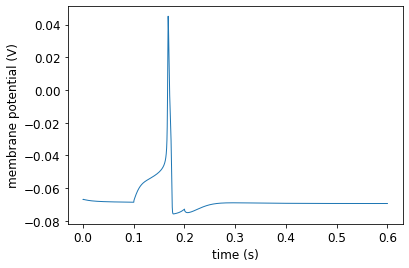

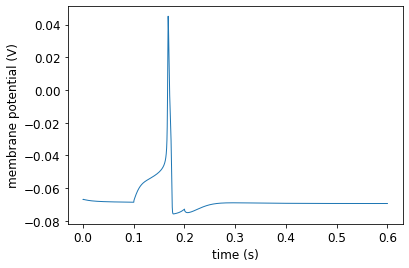

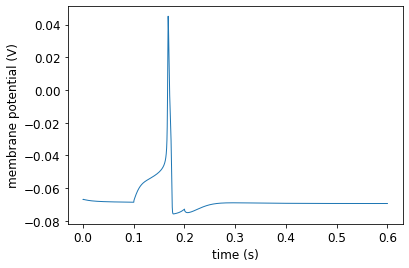

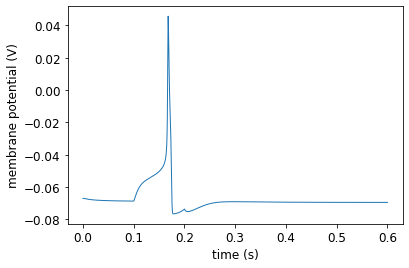

In [7]:
if __name__ == "__main__":
    main()